# Example: Learning the Policy of Agents
Previously, we looked at a system of self-governing trading agents positioned in a grid world. Each agent decides whether to buy, hold, or sell shares based on a set rule (also known as a policy) and the behaviors of their neighboring agents. Depending on their neighbors' actions, the agents make their own decisions for the next turn. 

Taking this a step further, in this example, we'll explore the inverse problem where an agent doesn't know the rule and instead needs to learn it by observing the actions of their neighbors.

* __Task 1__: We will utilize the previous simulation data to study how agents make decisions. Specifically, we aim to learn the rule, i.e., a policy that links the environment an agent perceives to the next action an agent chooses. To achieve this, we will employ reinforcement learning, particularly a Q-learning approach, to train a learning agent to replicate the decision-making process of agents in the simulation.
* __Task 2__: We'll compare the dynamics of the policy estimated by the agents with the known policy and see if they are the same or different. 

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

In [3]:
include("Include.jl");

## Prerequisites: Problem setup and constants
In this section, we set several constants that we'll use in the other tasks in this example. The comment beside each value describes the constant and permissible values. Let's begin with constants associated with the rule and the world and conclude by calculating the number of possible rules.

In [5]:
rule_index = 11111; # the Wolfram rule index, see below for the range of possible values. Default: 1635
number_of_colors = 3; # each the number of colors, i.e., the number of possible states for each agent. 
radius = 4; # size of the neighborhood an agent looks at. DO NOT CHANGE
number_of_rows = 2^8; # number of rows in the 2D agent grid. Default: 256. Larger values will **slow down** the computation below
number_of_columns = 2^8; # number of cols in the 2D agent grid. Default: 256. Larger values will **slow down** the computation below
number_of_agents = number_of_rows*number_of_columns; # the number of agents in the grid
middle = (number_of_rows / 2) |> Int; # the index of the middle agent (we have a square grid by default, so middle x = middle y)
number_of_iterations = 2^10; # the number of turns we simulate the system for. Default: 1024 turns
agent_view_width = 15; # ± this value from a center point will be used for plotting
agent_train_width = 150; # ± this value from a center point will be used for training

Next, let's set constants related to viewing and analyzing the simulation results below.

In [7]:
î,ĵ = 10,middle # agent location to view. This can be any value î ∈ 2:number_of_rows-1 and ĵ ∈ 2:number_of_cols-1
turn_index_to_view = 600; # turn to view in plots and training
view_period =  range(turn_index_to_view - agent_view_width, stop=turn_index_to_view+agent_view_width,step=1) |> collect; # plot range
train_period = range(turn_index_to_view - agent_train_width, stop=turn_index_to_view+agent_train_width,step=1) |> collect; # train range

Let's load the saved simulation file from the previous example. 

In [9]:
saved_simulation_dictionary = let
    path_to_saved_file = joinpath(_PATH_TO_DATA, "SavedState-TwoDimensionalWolframGame-N-256-x-256-R$(rule_index).jld2"); # path
    saved_simulation_dictionary = load(path_to_saved_file); # load
end

Dict{String, Any} with 5 entries:
  "frames"       => Dict(719=>[0 1 … 1 1; 1 2 … 2 1; … ; 1 2 … 1 1; 0 1 … 1 1],…
  "policy"       => MyTwoDimensionalTotalisticWolframRuleModel(11111, 4, 3, Dic…
  "colors"       => Dict{Int64, RGB}(0=>RGB{N0f8}(0.565, 0.933, 0.565), 2=>RGB{…
  "moves"        => Dict(4=>(0, 1), 2=>(1, 0), 3=>(0, -1), 1=>(-1, 0))
  "initialstate" => [0 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 0 1 … 1 1]

Grab some stuff from the saved file dictionary:

In [11]:
frames = saved_simulation_dictionary["frames"];
policy_model = saved_simulation_dictionary["policy"];
moves_dictionary = saved_simulation_dictionary["moves"];
initialstate = saved_simulation_dictionary["initialstate"];
my_color_dictionary  = saved_simulation_dictionary["colors"];

Now we use the `moves_dictionary::Dict{Int64, Tuple{Int64, Int64}}` dictionary to populate the `in_sample_dataset::Dict{Int64, Array{Int64,1}}` dictionary, which holds the neighborhood states and next state, encoded as a `data::Array{Int64,1}` array, for agent $(i,j)$. The keys of the `in_sample_dataset::Dict{Int64, Array{Int64,1}}` dictionary hold the turn index, while the value is the populated data array `[neighborhood ... | next state]` for that turn.
* First, we iterate over the turns of the simulation and access the current frame at `p,` which we save in the `my_current_frame::Array{Int64,2}` variable, and the next frame at index `p+1`, which we save in the `my_next_frame::Array{Int64,2}` variable.
* For the current frame, we calculate the neighborhood using [a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for), where we iterate over the `moves_dictionary::Dict{Int64, Tuple{Int64, Int64}}` dictionary, calculate each neighbor of the current state and save that in the `data::Array{Int64,2}` array, and then add the _next state_ for this agent to the last element of the `data::Array{Int64,2}` array. Finally, we store the populated data array `[neighborhood ... | next state]` in the `in_sample_dataset::Dict{Int64, Array{Int64,1}}` dictionary.

In [13]:
in_sample_dataset = let
    in_sample_dataset = Dict{Int64, Array{Int64,1}}();
    N = length(train_period);
    for p ∈ 1:(N - 1)  
        
        my_current_frame = train_period[p] |> t-> frames[t];
        my_next_frame = train_period[p+1] |> t-> frames[t];
        
        data = Array{Int64,1}(undef, radius+1)
        for k ∈ 1:radius
            Δ = moves_dictionary[k];
            i,j = î + Δ[1], ĵ + Δ[2];        
            data[k] = my_current_frame[i,j];
        end
        data[radius + 1] = my_next_frame[î,ĵ]; # reminder: the rule gives us the *next* state    
        in_sample_dataset[p] = data; 
    end
    in_sample_dataset
end

Dict{Int64, Vector{Int64}} with 300 entries:
  56  => [2, 0, 0, 0, 1]
  35  => [2, 0, 2, 0, 2]
  60  => [0, 0, 0, 0, 2]
  220 => [0, 0, 0, 1, 1]
  67  => [1, 0, 2, 0, 0]
  215 => [2, 2, 2, 2, 1]
  73  => [1, 2, 0, 0, 0]
  251 => [0, 2, 0, 0, 1]
  115 => [1, 1, 1, 2, 0]
  112 => [0, 0, 0, 2, 1]
  185 => [0, 1, 0, 0, 1]
  86  => [0, 1, 2, 2, 0]
  168 => [1, 0, 1, 0, 1]
  207 => [2, 0, 1, 2, 0]
  263 => [2, 2, 2, 1, 2]
  242 => [0, 0, 0, 2, 1]
  183 => [0, 0, 0, 0, 2]
  224 => [0, 0, 1, 1, 1]
  177 => [1, 1, 2, 1, 0]
  12  => [0, 0, 2, 1, 0]
  75  => [0, 0, 1, 1, 1]
  23  => [0, 2, 0, 0, 1]
  111 => [2, 0, 2, 2, 0]
  264 => [1, 2, 0, 1, 2]
  41  => [1, 2, 1, 2, 0]
  ⋮   => ⋮

In [14]:
number_of_states = policy_model.rule |> length
policy_model.rule

Dict{Int64, Int64} with 9 entries:
  0 => 2
  4 => 2
  5 => 0
  6 => 0
  2 => 1
  7 => 2
  8 => 1
  3 => 0
  1 => 1

## Task 1: Learn the policy function by observing agent choices
This task will utilize simulation data to study how agents make decisions. Specifically, we aim to learn the rule, i.e., a policy that links the environment an agent perceives to the next action an agent chooses. To achieve this, we will employ a Q-learning approach to train an agent to replicate the decision-making process of agents in the simulation. 

Similar to [the bandit problem we explored previously](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/bandits/#Bandit-Problems), let's start by formulating a `myworld(...)` function and some models of the world and the learning agent. Let's go!

### Specify the `myworld` function
The `myworld(...)` function takes a grid world model, [enoded as a `MyWolframGridWorldModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyWolframGridWorldModel), the turn index `t::Int64`, the current neighborhood configuration `s::Int64` and the proposed action `a::Int64`, i.e., the value of the _next agent state_ as arguments and returns a [Julia `Tuple` instance](https://docs.julialang.org/en/v1/manual/functions/#Tuples) holding the _observed next neigborhhod_ and the reward for being in the neighborhood `s` and transitioning to state `a`, i.e.., for taking action `a.` 
* __Reward__:The agent is provided with the world `model,` the turn index `t,` the state `s` (the current neighborhood configuration), and the action `a,` which is the agent's prediction of the choice for the next turn, whether it's to `{buy, hold, sell}.` Using the training data held in the `model` and the current time step `t,` we can determine the actual next action. We then compare the agent's prediction (encoded in `a`) with the actual value (encoded as `a′`). If they match, the agent receives a reward of `+1.1`; if they don't match, the agent receives a penalty of `-1.0`.
* __Next state__: Here, we assume that we know the playback frames completely; thus, we know the _next neighborhood configuration_. We get this value from the dataset. We pass the next configuration `s′` and the reward `r` back to the caller.

In [17]:
function myworld(model::MyWolframGridWorldModel, t::Int, s::Int, a::Int)::Tuple{Int, Float64}
    
    # initialize -
    s′ = nothing
    r = nothing
    
    # grab the parameters from the model -
    dataset = model.data;
    policymap = model.policymap;

    # compute the reward
    data = dataset[t]; # get data for turn = [neighborhood ... | next state]
    a′ = data[end]+1; # the last element is the next action (correct for zero)
    if (a′ == a) 
        r = 1.1;  # the agent got the next state correct
    else
        r = -1.0; # ooops. Wrong!
    end

    # get the next configuration - this assumes we have full knowledge of the playback frames
    next_state_data = dataset[t+1];
    my_neighbors = next_state_data[1:end-1];
    s′ = round(mean(my_neighbors), digits=2) |> value -> policymap[value] + 1; # correct for zero

    # return -
    return (s′,r);
end;

### Formulate the grid world model
Next, we build [a `MyWolframGridWorldModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyWolframGridWorldModel), using a [custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.build-Tuple{Type{MyWolframGridWorldModel},%20NamedTuple}). The [`MyWolframGridWorldModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyWolframGridWorldModel) holds data and functions associated with the simulation world. We save the world model in the `worlfram_gridworld_model::MyWolframGridWorldModel` variable.
* The [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.build-Tuple{Type{MyWolframGridWorldModel},%20NamedTuple}) takes the type of model we want to build, i.e., [`MyWolframGridWorldModel`](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyWolframGridWorldModel), and a [Julia `NamedTuple` instance](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) holding the required data fields; the `number_of_states::Int64` (number of neighborhood configurations), the `data::Dict{Int64, Array{Int64,1}}` field holds the training data the agent will learn from, the `policymap::Dict{Float64, Int64}` fields holds the `neighborhoodstatesmap::Dict{Float64, Int64}` dictionary, i.e., the map between $\bar{S}(t)$ and the neighborhood configuration indexes and the `world` function (the  `myworld(...)` function defined above). 

In [19]:
worlfram_gridworld_model = build(MyWolframGridWorldModel, (
    number_of_states = length(policy_model.rule),
    data = in_sample_dataset,
    policymap = policy_model.neighborhoodstatesmap,
    world = myworld, # this function is sampled by the Q-learning agent
));

### Formulate the Q-learning model
Now, let's construct [a Q-learning model, which is a `MyWolframRuleQLearningAgentModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyWolframRuleQLearningAgentModel), using a [custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.build-Tuple{Type{MyWolframRuleQLearningAgentModel},%20NamedTuple}). The learning model, which we save in the `learning_model::MyWolframRuleQLearningAgentModel` variable, holds data required for the agent to learn.
* The [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.build-Tuple{Type{MyWolframRuleQLearningAgentModel},%20NamedTuple}) takes the type that we want to construct, i.e., [the `MyWolframRuleQLearningAgentModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyWolframRuleQLearningAgentModel) and a [Julia `NamedTuple` instance](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) holding the required data fields; the `states::Int64` holds the states (neighborhood configurations), the `actions::Int64` holds the available actions (the _next states_ for an agent), `γ::Float64` is the discount rate ($0<\gamma\leq{1}$), `α::Float64` is the learning rate $\alpha\geq{0}$ and `Q::Array{Float64,2}` array, i.e.., the brain of the agent; we initialize the `Q` array to all zeros (the learning agents are just born, no knowledge of anything). 

In [21]:
learning_model = build(MyWolframRuleQLearningAgentModel, (
    states = range(1, stop=number_of_states, step=1) |> collect,
    actions = range(1, stop=number_of_colors, step=1) |> collect,
    γ = 0.5, # 0.5 worked
    α = 0.70,
    Q = zeros(number_of_states,number_of_colors),
));

### Learn the agent policy by analyzing the in-sample frames
Now that we have the world and learning models, we can run the learning routine, [encoded in the `sample(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.sample-Tuple{MyWolframRuleQLearningAgentModel,%20MyWolframGridWorldModel}), using the training examples the `in_sample_dataset::Dict{Int64, Array{Int64,1}}` dictionary. The [`sample(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.sample-Tuple{MyWolframRuleQLearningAgentModel,%20MyWolframGridWorldModel}) takes the leaning model, the world model and the number of training data examples, and returns an updated learning model, where the `Q`-array is updated with the results of the training.

In [23]:
learning_model = VLQuantitativeFinancePackage.sample(learning_model, worlfram_gridworld_model, 
    maxsteps = length(in_sample_dataset) - 1);

__What is in the updated `Q`-matrix?__ The `Q`-matrix, i.e., the agent's brain, started with all zeros. After training on many `[neighborhood ... | next state]` examples, the entries in the `Q`-matrix have been updated. The rows of `Q` are the neighborhood configurations (input state), while the columns correspond to actions; the elements of `Q` hold the cumulative reward the learning agent has received by taking action `a`, i.e., moving to $s\in$`{buy, hold, sell}` on the _next turn_, given the current neighborhood configuration. 

In [25]:
Q̂ = learning_model.Q

9×3 Matrix{Float64}:
 -0.469      -0.000125278  2.19283
 -0.149373    2.19061      0.0884252
 -0.0103774   2.18999      0.0159221
  2.19728     0.0610072    0.00087249
  0.0323787   0.013488     2.19021
  2.19763     0.0880581    0.0598797
  2.19591    -0.1479       0.0648491
 -0.460367   -0.310316     2.18856
  0.0398833   0.0          0.0877013

The `Q̂` is the best brain found so far. However, we typically don't use the `Q̂`-matrix directly to make decisions. Instead, we formulate a policy function $\pi:\mathcal{S}\rightarrow\mathcal{A}$, i.e., given a state $s\in\mathcal{S}$ in the set of possible states $\mathcal{S}$, the policy function $\pi(s)$ returns the best action $a\in\mathcal{A}$ in the set of possible actions $\mathcal{A}$ found so for that state. We implement the policy $\pi(s)$ in the  `π̂::Dict{Int64, Int64}` dictionary.
* We compute the entries of the policy dictionary `π̂::Dict{Int64, Int64}` by taking the [`argmax(...)` for each row of the `Q`-matrix](https://docs.julialang.org/en/v1/base/collections/#Base.argmax) using a [`for-loop` over the states `s`](https://docs.julialang.org/en/v1/base/base/#for). The [`argmax(...)` function](https://docs.julialang.org/en/v1/base/collections/#Base.argmax) returns the index of the maximum element in a set of elements, in this case, the action `a` (column) with the maximum cumulative reward for a state (row). 
* The `+1` and `-1` modifications account for `zero`- versus `one`-based arrays; notice that we iterate over $s\in\mathcal{S}$ which is `zero`-based, but all arrays in Julia are `one`-based, hence the need for the $\pm$`1` corrections.

In [27]:
π̂ = Dict{Int64,Int64}()
for s ∈ 0:(number_of_states - 1)
    π̂[s] = argmax(Q̂[s+1,:]) - 1;
end

### Is the estimated policy and the Wolfram rule the same?
Finally, let's see how well our learning agent figured out the rule used by our simulation agents. We'll use the estimated policy function $\hat{\pi}(s)$ function to compute the learned action $\hat{a}$ and compare that to the actual action $a$ for each system state, i.e., for each neighborhood configuration. 

#### Summary
`Unhide` the code block to see how we computed a table that displays the learned action $\hat{a}$, the actual action $a$, and the correctness of the prediction [using the `pretty_tables(...)` function exported by the PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl).
* Given the default setup, the learning agent reproduces the simulation agents' decision logic by simply (sequentially) watching many `[neighborhood ... | next state]` training examples. (Note: because of the random nature of the approach, your answers may be different!)
* __Wow! That's amazing, but what does it mean if we miss some neighborhoods?__ Depending upon the rule, we may see cases in our training data that occur with a low frequency $\leq$ `0.01`. Consequently, the learning agent doesn't encounter this neighborhood configuration often, making it difficult for the agent to learn and replicate this particular case.
* __Okay, we're not capturing some low-frequency cases__. Can we address this issue? To resolve this, we must ensure that all neighborhood configurations are represented in the training data. This can be done by adjusting the simulation turns included in the data or by changing the agent(s) we observe. We can also adjust our Q-learner's learning hyperparameters $(\alpha,\gamma)$.

In [29]:
let
    table_df = DataFrame();
    for s ∈ 0:(number_of_states - 1)

        a = policy_model.rule[s]; # true action for state s
        â = π̂[s]; # estimated action for state s
        
        row_df = (
            s = s,
            a = a,
            â = â,
            correct = (a==â)
        );
        push!(table_df, row_df);
    end
    pretty_table(table_df)
end

┌───────┬───────┬───────┬─────────┐
│     s │     a │     â │ correct │
│ Int64 │ Int64 │ Int64 │    Bool │
├───────┼───────┼───────┼─────────┤
│     0 │     2 │     2 │    true │
│     1 │     1 │     1 │    true │
│     2 │     1 │     1 │    true │
│     3 │     0 │     0 │    true │
│     4 │     2 │     2 │    true │
│     5 │     0 │     0 │    true │
│     6 │     0 │     0 │    true │
│     7 │     2 │     2 │    true │
│     8 │     1 │     2 │   false │
└───────┴───────┴───────┴─────────┘


### What rule did the Q-learning agent arrive at?
What rule did the Q-learning agent come up with? We can compute the estimated rule number from the estimated policy function $\hat{\pi}(s)$.  Policies (rules) can be enumerated by counting [in base `b`](https://en.wikipedia.org/wiki/Numeral_system#:~:text=In%20a%20positional%20base%20b,in%20the%20figure%20is%20used.), where `b = number_of_colors`. The base `b` representation of a number uses the digit set:
$$
\begin{equation}
\mathcal{D}_{b} = \left\{0, 1, \dots, (b - 1)\right\}
\end{equation}
$$
Thus, for any $n\geq{0}$ and $b\geq{2}$, there is a string of k-digits $\left(a_{k-1}\,a_{k-2},\dots,a_{2}\,a_{1}a_{0}\right)_{b}$
where $a_{i}\in\mathcal{D}_{b}$ such that the `base-10` representation of the number is given by:
$$
\begin{equation}
n = \sum_{j=0}^{k-1}a_{j}\cdot{b^{j}}
\end{equation}
$$
where $a_{j}$ denotes the digit in position $j$, the quantity `b` denotes the base, and `k = number_of_colors`. Thus, our manual policy can be written as `(022110002)₃` in base `b = 3`. Wow! Neat. But that is _not what we need, right_? We need the base `base 10` representation of `(022110002)₃`; let's write some code to do this conversion.

In [31]:
estimated_rule_index = [π̂[i]*(number_of_colors^(i)) for i ∈ 0:(number_of_states - 1)] |> sum
println("The rule_index for the estimated policy = $(estimated_rule_index)")

The rule_index for the estimated policy = 17672


## Task 2: Compare the estimated and actual policy
In this task, we'll compare the dynamics of the estimated policy with the true policy to see how they differ given the same initial configuration.

In [33]:
estimated_policy_model = build(MyTwoDimensionalTotalisticWolframRuleModel, (
    index = estimated_rule_index, # not the same as the original rule
    colors = number_of_colors,
    radius = radius,
));

### Run the simulation
We simulate the evolution of the agents in the grid world specified in the `initialstate::Array{Int64,2}` array for the rule described in the `estimated_policy_model::MyTwoDimensionalTotalisticWolframRuleModel` instance, [using the `solve(...)` method exported by the `VLQuantitativeFinancePackage.jl` package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.solve-Tuple{MyTwoDimensionalTotalisticWolframRuleModel,%20Matrix{Int64}}).
* The [`solve(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.solve-Tuple{MyTwoDimensionalTotalisticWolframRuleModel,%20Matrix{Int64}}) takes three arguments: the `policy_model::MyTwoDimensionalTotalisticWolframRuleModel` instance, the `initialstate::Array{Int64,2}` of the square population of agents, and the number of turns to simulate in the `steps::Int64` argument.
* The [`solve(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.solve-Tuple{MyTwoDimensionalTotalisticWolframRuleModel,%20Matrix{Int64}}) returns the `frames::Dict{Int64, Array{Int64,2}}` dictionary which holds the state of the system, encoded as a `number_of_rows`$\times$`number_of_cols` array holding the agent state $s_{ij}$ values, for each turn, starting at `0` up to `number_of_iterations.` The keys of the `estimated_policy_frames::Dict{Int64, Array{Int64,2}}` dictionary are the time index, while the values are frames of the system at that time index.

In [35]:
estimated_policy_frames = solve(estimated_policy_model, initialstate, steps = number_of_iterations);

To access the state of the system, i.e., the states of each agent in the grid world, we pass the turn index to the `estimated_policy_frames::Dict{Int64, Array{Int64,2}}` dictionary, which returns the state frame. For example, we show the state of all agents at `turn_index_to_view::Int64` in the `myframe::Array{Int64,2}` variable.
* The data in the `myframe::Array{Int64,2}` variable is a snapshot of the system state, i.e., the state each agent is in at this turn in the simulation. However, looking at a block of [Int values](https://docs.julialang.org/en/v1/manual/integers-and-floating-point-numbers/#Integers-and-Floating-Point-Numbers) may not be super informative, so let's develop of some other ways to visualize how the agents in the grid world are making decisions as a function of time.

In [37]:
trueframe = frames[turn_index_to_view]

256×256 Matrix{Int64}:
 0  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  0  1  0  0  0  2  0  2  2  0  1     0  0  0  2  0  0  0  0  0  2  0  1
 1  0  1  0  1  2  2  2  2  0  0  1  1     1  0  0  0  0  2  2  2  0  1  2  1
 1  0  2  0  2  0  1  2  1  1  2  2  1     2  2  1  0  2  2  1  1  0  0  0  1
 1  0  2  2  2  1  0  2  1  1  1  1  2     2  1  0  1  0  1  0  1  2  0  0  1
 1  0  2  0  1  0  0  2  0  1  1  0  2  …  1  2  2  0  2  2  1  2  0  0  2  1
 1  0  2  1  2  0  1  0  0  1  0  2  1     1  1  1  1  1  0  0  0  1  2  1  1
 1  0  1  2  2  1  2  1  0  0  1  1  1     2  1  2  2  2  2  1  2  2  1  0  1
 1  0  0  2  2  0  1  0  0  2  1  1  1     0  2  1  2  1  0  1  2  2  0  1  1
 1  2  2  0  1  0  2  2  0  0  1  2  0     2  2  2  2  1  2  0  0  2  1  0  1
 1  1  0  1  0  2  0  0  0  0  0  0  0  …  2  1  1  1  1  1  1  0  1  0  0  1
 1  0  2  2  2  0  0  0  0  1  0  0  0     1  0  2  2  1  1  2  2  1  0  0  1
 1  2  2  0  1  0  2  0  1  2  1  0  0   

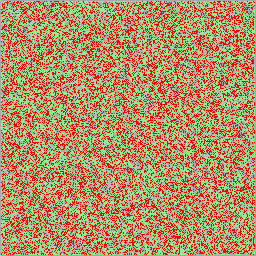

In [38]:
let
    frame_to_visualize = trueframe;
    new_display_frame = Array{RGB,2}(undef, number_of_rows, number_of_columns);
    for j ∈ 1:number_of_rows
        for k ∈ 1:number_of_columns
            new_display_frame[j,k] = frame_to_visualize[j,k] |> s -> my_color_dictionary[s];
        end
    end
    display(new_display_frame)
end

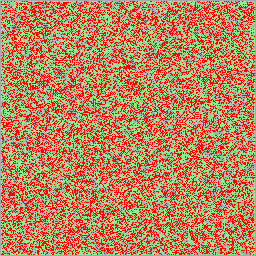

In [39]:
let
    myframe = estimated_policy_frames[turn_index_to_view]
    frame_to_visualize = myframe;
    new_display_frame = Array{RGB,2}(undef, number_of_rows, number_of_columns);
    for j ∈ 1:number_of_rows
        for k ∈ 1:number_of_columns
            new_display_frame[j,k] = frame_to_visualize[j,k] |> s -> my_color_dictionary[s];
        end
    end
    display(new_display_frame)
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.